In [15]:
from typing_extensions import Literal, TypedDict
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command # using the command we can pass the command from one agent to another agent
from dotenv import load_dotenv
from IPython.display import display, Image
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated # just to mention the metadata
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
load_dotenv()

True

In [3]:
import os

groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(groq_api_key=groq_api_key, model_name="deepseek-r1-distill-llama-70b")

llm.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [4]:
tavily_tool = TavilySearchResults()

In [5]:
tavily_tool.invoke("gdp of india?")

[{'url': 'https://tradingeconomics.com/india/gdp',
  'content': 'The Gross Domestic Product (GDP) in India was worth 3567.55 billion US dollars in 2023, according to official data from the World Bank. The GDP value of India represents 3.38 percent of the world economy. source: World Bank [...] GDP in India averaged 785.41 USD Billion from 1960 until 2023, reaching an all time high of 3567.55 USD Billion in 2023 and a record low of 37.03 USD Billion in 1960. This page provides the latest reported value for - India GDP - plus previous releases, historical high and low, short-term forecast and long-term prediction, economic calendar, survey consensus and news. India GDP - values, historical data and charts - was last updated on May of 2025. [...] GDP in India is expected to reach 3792.00 USD Billion by the end of 2025, according to Trading Economics global macro models and analysts expectations. In the long-term, the India GDP is projected to trend around 4043.00 USD Billion in 2026 and 4

In [6]:
@tool 
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\sowmy\AppData\Local\Temp\ipykernel_9288\4245526608.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\sowmy\AppData\Local\Temp\ipykernel_9288\4245526608.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [7]:
repl = PythonREPL()

In [8]:
code = """ 
x = 5
y = x * 2
print(y)
"""

In [9]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [10]:
members = ["researcher", "coder"]

In [12]:
options = members+["FINISH"]

In [13]:
options

['researcher', 'coder', 'FINISH']

In [16]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH"""
    next: Literal['researcher', 'coder', 'FINISH']

In [17]:
class State(MessagesState):
    next: str

In [18]:
system_prompt = f""" 
You are a supervisor, tasked with managing a conversation between the following workers: {members}.
Given the following user request, respond with the worker to act next.
Each worker will perform a task and respond with their results and status.
When finished, respond with FINISH.
"""

In [19]:
[{"role": "system", "content": system_prompt}, ]

[{'role': 'system',
  'content': " \nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder'].\nGiven the following user request, respond with the worker to act next.\nEach worker will perform a task and respond with their results and status.\nWhen finished, respond with FINISH.\n"}]

In [20]:
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state['messages']
    
    response = llm.with_structured_output(Router).invoke(messages)
    
    goto = response['next']
    
    print("below my goto ****************")
    
    print(goto)
    
    if goto == "FINISH":
        goto = END 
    
    return Command(goto=goto, update={"next": goto})

In [21]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result['messages'][-1].content, name="researcher")
            ]
        },
        goto = "supervisor"
    )

In [24]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(llm, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto = "supervisor"
    )

In [25]:
graph = StateGraph(State)

graph.add_node("supervisor", supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)

graph.add_edge(START, "supervisor")

app = graph.compile()

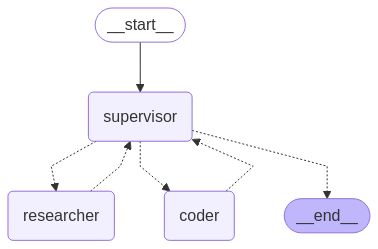

In [26]:
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
for s in app.stream({"messages": [("user", "what's the square of 42?")]}, subgraphs=True):
    print(s)
    print("----")

below my goto ****************
researcher
((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:2e62a0aa-a66d-a8d0-bf3d-f69a16d635ab',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hkz7', 'function': {'arguments': '{"query":"square of 42"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 207, 'prompt_tokens': 177, 'total_tokens': 384, 'completion_time': 0.793735647, 'prompt_time': 0.011923797, 'queue_time': 0.055909311, 'total_time': 0.805659444}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7814304c-93fb-4a5b-9ac3-d27330ca2401-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'square of 42'}, 'id': 'call_hkz7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 177, 'output_tokens': 207, 'total_tokens': 384})]}})
----
(('researcher:2